# Загрузка библиотек

In [16]:
!python.exe -m pip install --upgrade pip
!pip install opencv-python numpy scipy imutils pandas opencv-contrib-python filterpy seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


# Импорты

In [1]:
import zipfile
import tempfile
import os
import requests
import cv2
from io import BytesIO
import logging
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import time
import random
from tqdm import tqdm
import json

# Анализ данных

In [2]:
logging.basicConfig(filename='app.log', level=logging.INFO, 
                    format='%(asctime)s - %(levelname)s - %(message)s')

video_folder = "data/videos"

## Загрузка и проверка данных

In [5]:
url = "https://www.dropbox.com/scl/fo/556goush7rp217ujq8xgc/h?e=2&preview=my_video-138.mkv&rlkey=eiixyhslpb8qlh9v9d9yxg2zv&dl=0&dl=1"

In [26]:
def download_and_extract_zip(zip_url, extract_to):
    logging.info(f"zip archive downloading: {zip_url}")
    
    try:
        response = requests.get(zip_url)
        response.raise_for_status()
        
        zip_data = BytesIO(response.content)
        logging.info(f"Succesfully downlaod! Size is {len(response.content)} bytes")
        
        with zipfile.ZipFile(zip_data, 'r') as zip_ref:
            file_list = zip_ref.namelist()
            logging.info(f"Downloading files: {file_list}")
            
            zip_ref.extractall(extract_to)
            logging.info(f"Archive path: {extract_to}")
        
        return extract_to, file_list
        
    except Exception as e:
        logging.error(f"Error during downloading: {e}")
        return None, []

In [27]:
def process_video_files(directory, file_list):
    video_extensions = ['.mp4', '.avi', '.mkv', '.mov', '.wmv']
    video_files = []

    logging.info("Searching video files")
    
    for filename in file_list:
        file_path = os.path.join(directory, filename)
        if os.path.isfile(file_path) and any(filename.lower().endswith(ext) for ext in video_extensions):
            video_files.append(file_path)
            logging.info(f"File was found: {filename}")
    
    return video_files

In [31]:
def test_video_file(video_path):
    logging.info(f"Try to check video {os.path.basename(video_path)}")
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        logging.error("Don't manage to open file")
        return False
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    logging.info(f"File opened successfully\n\tSize: {width}-{height}\n\tFPS: {fps:.2f}\n\tFrames: {total_frames}")
    
    ret, frame = cap.read()
    if ret:
        if width > 800:
            frame = cv2.resize(frame, (800, int(800 * height / width)))
        
        cv2.imshow(f'Preview: {os.path.basename(video_path)}', frame)
        cv2.waitKey(2000)
        cv2.destroyAllWindows()
    
    cap.release()
    return True

In [32]:
def main_zip_processing(zip_url):
    logging.info("Start downloading and file extracting")
    
    extract_dir, file_list = download_and_extract_zip(zip_url, video_folder)
    
    if not extract_dir:
        logging.error("Don't manage to process archive")
        return
    
    video_files = process_video_files(extract_dir, file_list)
    
    if not video_files:
        logging.error("There are no files in archive")
        return
    
    logging.info(f"Files in archive: {len(video_files)}")
    results = []
    for video_path in video_files:
        success = test_video_file(video_path)
        results.append({
            'path': video_path,
            'name': os.path.basename(video_path),
            'success': success
        })
    
    logging.info("Results:")
    for result in results:
        logging.info(f"Success: {result['name']}") if result['success'] else logging.error(f"Error: {result['name']}")
    
    return results, extract_dir

In [33]:
main_zip_processing(url)

([{'path': 'data/videos\\my_video-137.mkv',
   'name': 'my_video-137.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-141.mkv',
   'name': 'my_video-141.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-151.mkv',
   'name': 'my_video-151.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-157.mkv',
   'name': 'my_video-157.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-163.mkv',
   'name': 'my_video-163.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-136.mkv',
   'name': 'my_video-136.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-138.mkv',
   'name': 'my_video-138.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-139.mkv',
   'name': 'my_video-139.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-142.mkv',
   'name': 'my_video-142.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-143.mkv',
   'name': 'my_video-143.mkv',
   'success': True},
  {'path': 'data/videos\\my_video-146.mk

## EDA

### Проверяем схожесть видео по параметрам видео

In [3]:
def apply_func_by_video(func, video_folder, *args, video_count=None):
    video_extensions = ('.mp4', '.avi', '.mov', '.mkv', '.wmv', '.flv', '.webm')
    if video_count:
        counter = 0
    results = []
    for filename in os.listdir(video_folder):
        if filename.lower().endswith(video_extensions):

            video_path = os.path.join(video_folder, filename)
            print(f"\n=== Анализ видео: {filename} ===")
            
            try:
                results.append(func(video_path, *args))
                
            except Exception as e:
                print(f"Ошибка при анализе {filename}: {e}")
        if video_count:
            counter += 1
            if counter == video_count:
                break
    return results

In [4]:
def analyze_video_properties(video_path):
    """
    Анализ технических характеристик видео
    """
    cap = cv2.VideoCapture(video_path)
    
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    print(f"Разрешение: {width}-{height}")
    print(f"\tFPS: {fps}")
    print(f"\tВсего кадров: {total_frames}")
    print(f"\tДлительность: {total_frames/fps:.1f} сек")
    for i in range(0, total_frames, int(fps)):
        cap.set(cv2.CAP_PROP_POS_FRAMES, i)
        ret, frame = cap.read()
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            brightness = np.mean(gray)
            print(f"\tКадр {i}: яркость = {brightness:.1f}")
    
    cap.release()
    return width, height, fps, total_frames

In [5]:
apply_func_by_video(analyze_video_properties, video_folder)


=== Анализ видео: my_video-136.mkv ===
Разрешение: 640-480
	FPS: 120.10135135135135
	Всего кадров: 254
	Длительность: 2.1 сек
	Кадр 0: яркость = 129.8
	Кадр 120: яркость = 129.9

=== Анализ видео: my_video-137.mkv ===
Разрешение: 640-480
	FPS: 120.10135135135135
	Всего кадров: 998
	Длительность: 8.3 сек
	Кадр 0: яркость = 130.1
	Кадр 120: яркость = 130.0
	Кадр 240: яркость = 129.9
	Кадр 360: яркость = 119.2
	Кадр 480: яркость = 130.5
	Кадр 600: яркость = 123.6
	Кадр 720: яркость = 123.9
	Кадр 840: яркость = 123.8

=== Анализ видео: my_video-138.mkv ===
Разрешение: 640-480
	FPS: 120.10135135135135
	Всего кадров: 1070
	Длительность: 8.9 сек
	Кадр 0: яркость = 123.8
	Кадр 120: яркость = 123.9
	Кадр 240: яркость = 123.7
	Кадр 360: яркость = 132.5
	Кадр 480: яркость = 141.0
	Кадр 600: яркость = 123.9
	Кадр 720: яркость = 123.9
	Кадр 840: яркость = 123.9

=== Анализ видео: my_video-139.mkv ===
Разрешение: 640-480
	FPS: 120.10135135135135
	Всего кадров: 1356
	Длительность: 11.3 сек
	Кадр 0: 

[(640, 480, 120.10135135135135, 254),
 (640, 480, 120.10135135135135, 998),
 (640, 480, 120.10135135135135, 1070),
 (640, 480, 120.10135135135135, 1356),
 (640, 480, 120.10135135135135, 6525),
 (640, 480, 120.10135135135135, 2391),
 (640, 480, 120.10135135135135, 1797),
 (640, 480, 120.10135135135135, 1719),
 (640, 480, 120.10135135135135, 8069),
 (640, 480, 120.10135135135135, 7855),
 (640, 480, 120.10135135135135, 194),
 (640, 480, 120.10135135135135, 7419),
 (640, 480, 120.10135135135135, 5775),
 (640, 480, 120.10135135135135, 1581),
 (640, 480, 120.10135135135135, 1971),
 (640, 480, 120.10135135135135, 1339),
 (640, 480, 120.10135135135135, 3632),
 (640, 480, 120.10135135135135, 3237),
 (640, 480, 120.10135135135135, 1555),
 (640, 480, 120.10135135135135, 2501),
 (640, 480, 120.10135135135135, 3508),
 (640, 480, 120.10135135135135, 1607),
 (640, 480, 120.10135135135135, 1505),
 (640, 480, 120.10135135135135, 11573),
 (640, 480, 120.10135135135135, 1841),
 (640, 480, 120.10135135135

In [8]:
def analyze_contrast_and_noise(video_path):
    """
    Анализ контрастности и шума
    """
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    contrast_values = []
    noise_levels = []
    
    sample_frames = total_frames // 120
    sample_indices = np.linspace(0, total_frames-1, int(sample_frames), dtype=int)
    
    for i, frame_idx in enumerate(sample_indices):
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_idx)
        ret, frame = cap.read()
        
        if ret:
            gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
            
            # Анализ контрастности
            contrast = np.std(gray)
            contrast_values.append(contrast)
            
            # Анализ шума
            kernel = np.array([[-1,-1,-1], [-1,8,-1], [-1,-1,-1]])
            high_freq = cv2.filter2D(gray, -1, kernel)
            noise_level = np.std(high_freq)
            noise_levels.append(noise_level)
            
            print(f"   Кадр {frame_idx}: контраст = {contrast:.1f}, шум = {noise_level:.1f}")
    
    cap.release()
    
    # Анализ результатов
    avg_contrast = np.mean(contrast_values)
    avg_noise = np.mean(noise_levels)
    
    print(f"\nСредняя контрастность: {avg_contrast:.1f}")
    print(f"Средний уровень шума: {avg_noise:.1f}")
    
    # Интерпретация результатов
    if avg_contrast > 50:
        print("Высокая контрастность - рыбы должны хорошо выделяться")
    elif avg_contrast > 25:
        print("Средняя контрастность - может потребоваться улучшение")
    else:
        print("Низкая контрастность - сложные условия для детекции")
    
    return avg_contrast, avg_noise

In [9]:
apply_func_by_video(analyze_contrast_and_noise, video_folder)


=== Анализ видео: my_video-136.mkv ===
   Кадр 0: контраст = 26.2, шум = 7.1

Средняя контрастность: 26.2
Средний уровень шума: 7.1
Средняя контрастность - может потребоваться улучшение

=== Анализ видео: my_video-137.mkv ===
   Кадр 0: контраст = 26.1, шум = 7.6
   Кадр 142: контраст = 25.9, шум = 7.0
   Кадр 284: контраст = 50.2, шум = 16.1
   Кадр 427: контраст = 38.5, шум = 9.9
   Кадр 569: контраст = 41.9, шум = 11.4
   Кадр 712: контраст = 26.0, шум = 6.2
   Кадр 854: контраст = 26.2, шум = 6.8

Средняя контрастность: 33.5
Средний уровень шума: 9.3
Средняя контрастность - может потребоваться улучшение

=== Анализ видео: my_video-138.mkv ===
   Кадр 0: контраст = 26.1, шум = 6.6
   Кадр 152: контраст = 45.8, шум = 14.8
   Кадр 305: контраст = 45.3, шум = 30.2
   Кадр 458: контраст = 44.8, шум = 27.4
   Кадр 610: контраст = 26.1, шум = 6.3
   Кадр 763: контраст = 26.1, шум = 6.0
   Кадр 916: контраст = 26.2, шум = 7.4

Средняя контрастность: 34.3
Средний уровень шума: 14.1
Средняя

### Анализ изображений

In [4]:
img1 = cv2.imread('data/extracted_frames/my_video-137/my_video-137_frame_000194.jpg')
img2 = cv2.imread('data/extracted_frames/my_video-137/my_video-137_frame_000294.jpg')
img3 = cv2.imread('data/extracted_frames/my_video-143/my_video-143_frame_000443.jpg')
img4 = cv2.imread('data/extracted_frames/my_video-143/my_video-143_frame_000571.jpg')
img5 = cv2.imread('data/extracted_frames/my_video-144/my_video-144_frame_003812.jpg')
img6 = cv2.imread('data/extracted_frames/my_video-148/my_video-148_frame_001667.jpg')

#### Изучим доминирующие цвета на тестовых изображениях

In [23]:
def analyze_colors_histogram(image, num_colors=10):
    """
    Показывает гистограммы и доминирующие цвета
    """
    # Загрузка изображения
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Разделение на каналы
    colors = ('r', 'g', 'b')
    
    # Построение гистограмм для каждого канала
    plt.figure(figsize=(15, 5))
    
    for i, color in enumerate(colors):
        histogram = cv2.calcHist([image_rgb], [i], None, [256], [0, 256])
        plt.subplot(1, 3, i+1)
        plt.plot(histogram, color=color)
        plt.xlim([0, 256])
        plt.title(f'Гистограмма {color.upper()}-канала')
    
    plt.tight_layout()
    plt.show()
    
    return image_rgb

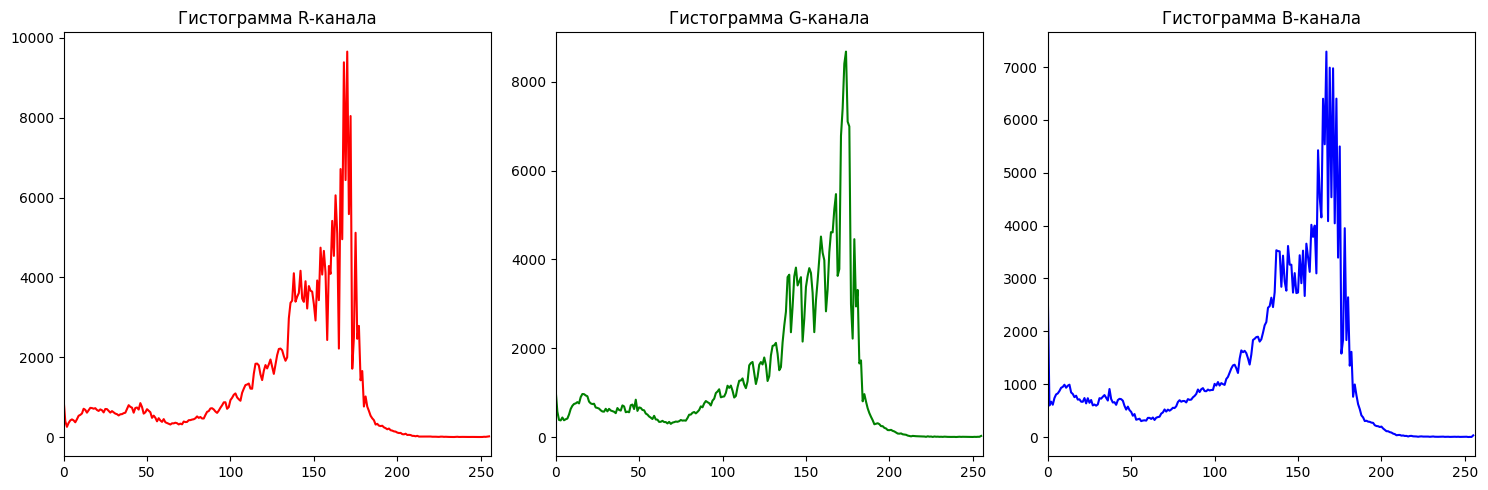

In [24]:
img_hist = analyze_colors_histogram(img3)

In [34]:
def detect_color_ranges(image):
    """
    Обнаруживает различные цветовые диапазоны и показывает маски
    """
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    # Определение диапазонов цветов в HSV
    color_ranges = {
        'Красный (нижний)': ([0, 100, 100], [10, 255, 255]),
        'Красный (верхний)': ([170, 100, 100], [180, 255, 255]),
        'Оранжевый': ([11, 100, 100], [20, 255, 255]),
        'Желтый': ([21, 100, 100], [30, 255, 255]),
        'Зеленый': ([31, 100, 100], [80, 255, 255]),
        'Голубой': ([81, 100, 100], [100, 255, 255]),
        'Синий': ([101, 100, 100], [130, 255, 255]),
        'Фиолетовый': ([131, 100, 100], [150, 255, 255]),
        'Розовый': ([151, 100, 100], [169, 255, 255]),
        'Черный': ([0, 0, 0], [180, 50, 50]),
        'Белый': ([0, 0, 200], [180, 30, 255]),
        'Серый': ([0, 0, 50], [180, 30, 200])
    }
    
    # Создаем визуализацию
    plt.figure(figsize=(15, 10))
    
    # Исходное изображение
    plt.subplot(4, 4, 1)
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title('Исходное изображение')
    plt.axis('off')
    
    # Для каждого цветового диапазона
    for idx, (color_name, (lower, upper)) in enumerate(color_ranges.items(), 2):
        lower_np = np.array(lower)
        upper_np = np.array(upper)
        
        # Создаем маску
        mask = cv2.inRange(hsv, lower_np, upper_np)
        
        # Применяем маску
        result = cv2.bitwise_and(image, image, mask=mask)
        
        # Вычисляем процент покрытия
        percentage = np.sum(mask > 0) / (mask.shape[0] * mask.shape[1]) * 100
        
        # Отображаем если есть этот цвет
        if percentage > 0.1:  # Порог 0.1%
            plt.subplot(4, 4, idx)
            plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
            plt.title(f'{color_name}\n{percentage:.1f}%')
            plt.axis('off')
    
    plt.tight_layout()
    plt.show()

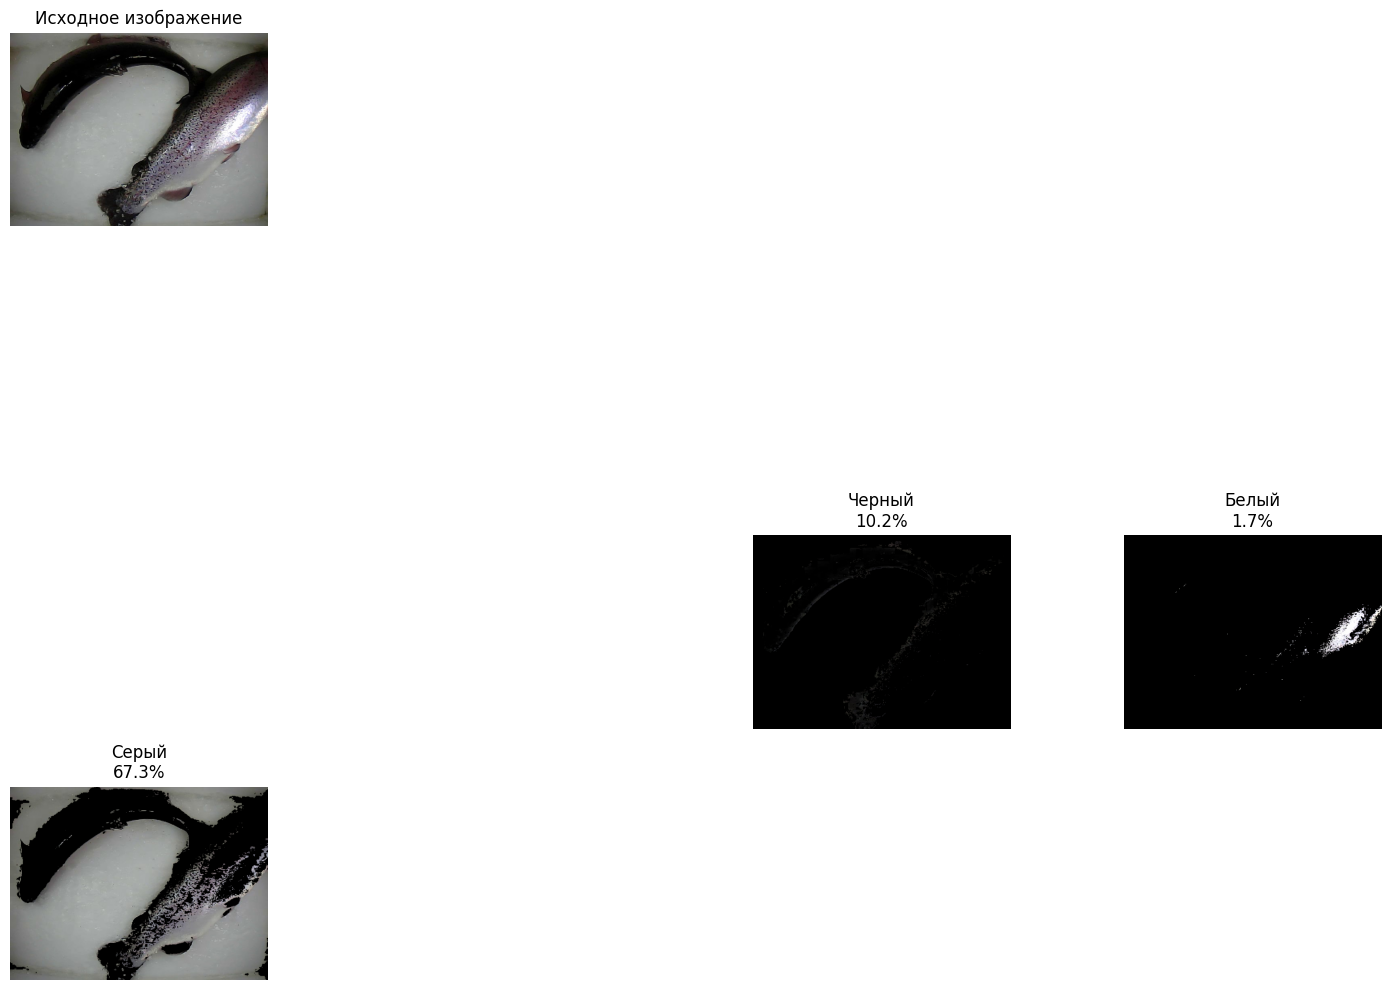

In [35]:
detect_color_ranges(img6)

In [36]:
def interactive_color_picker(image):
    """
    Интерактивный инструмент: кликайте по изображению чтобы узнать цвет пикселя
    """
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    def click_event(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONDOWN:
            # Получаем цвет в разных пространствах
            bgr = image[y, x]
            rgb = image_rgb[y, x]
            hsv = image_hsv[y, x]
            
            # Конвертируем в HEX
            hex_color = '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])
            
            # Выводим информацию
            print("\n" + "="*50)
            print(f"Координаты: ({x}, {y})")
            print(f"BGR: {bgr}")
            print(f"RGB: {rgb}")
            print(f"HSV: {hsv}")
            print(f"HEX: {hex_color}")
            
            # Определяем примерный цвет
            h, s, v = hsv
            color_name = "Неопределенный"
            
            if v < 50:
                color_name = "Черный"
            elif s < 50 and v > 200:
                color_name = "Белый"
            elif s < 50:
                color_name = "Серый"
            elif h < 10 or h > 170:
                color_name = "Красный"
            elif 10 <= h < 25:
                color_name = "Оранжевый"
            elif 25 <= h < 35:
                color_name = "Желтый"
            elif 35 <= h < 85:
                color_name = "Зеленый"
            elif 85 <= h < 110:
                color_name = "Голубой"
            elif 110 <= h < 130:
                color_name = "Синий"
            elif 130 <= h < 150:
                color_name = "Фиолетовый"
            elif 150 <= h < 170:
                color_name = "Розовый"
            
            print(f"Примерный цвет: {color_name}")
            
            # Показываем цвет рядом
            color_display = np.zeros((100, 100, 3), dtype=np.uint8)
            color_display[:, :] = rgb
            
            cv2.imshow('Selected Color', color_display)
            cv2.setWindowTitle('Selected Color', f'Color: {hex_color}')
            
            # Рисуем круг на основном изображении
            marked = image.copy()
            cv2.circle(marked, (x, y), 5, (0, 255, 0), -1)
            cv2.imshow('Image', marked)
    
    # Отображаем изображение
    cv2.imshow('Image', image)
    cv2.setMouseCallback('Image', click_event)
    
    print("Кликайте по изображению чтобы узнать цвет пикселя")
    print("Нажмите 'q' для выхода")
    
    while True:
        key = cv2.waitKey(1) & 0xFF
        if key == ord('q'):
            break
    
    cv2.destroyAllWindows()

In [60]:
# Использование
interactive_color_picker(img1)

Кликайте по изображению чтобы узнать цвет пикселя
Нажмите 'q' для выхода

Координаты: (4, 45)
BGR: [35 54 61]
RGB: [61 54 35]
HSV: [ 22 109  61]
HEX: #3d3623
Примерный цвет: Оранжевый

Координаты: (626, 43)
BGR: [ 7 25 32]
RGB: [32 25  7]
HSV: [ 22 199  32]
HEX: #201907
Примерный цвет: Черный

Координаты: (434, 432)
BGR: [53 42 75]
RGB: [75 42 53]
HSV: [170 112  75]
HEX: #4b2a35
Примерный цвет: Неопределенный


KeyboardInterrupt: 

#### Подготовка фильтра

In [5]:
img1 = cv2.imread('data/extracted_frames/my_video-137/my_video-137_frame_000194.jpg')
img2 = cv2.imread('data/extracted_frames/my_video-137/my_video-137_frame_000294.jpg')
img3 = cv2.imread('data/extracted_frames/my_video-143/my_video-143_frame_000443.jpg')
img4 = cv2.imread('data/extracted_frames/my_video-143/my_video-143_frame_000571.jpg')
img5 = cv2.imread('data/extracted_frames/my_video-144/my_video-144_frame_003812.jpg')
img6 = cv2.imread('data/extracted_frames/my_video-148/my_video-148_frame_001667.jpg')

In [6]:
def enhance_extremes_filter(image, black_threshold=25, white_threshold=170):
    """
    Усиливает контраст между черным (0-25) и белым (170-255)
    
    Args:
        black_threshold: порог для черного (0-25)
        white_threshold: порог для белого (170-255)
    """
    # Конвертируем в float для точных вычислений
    img_float = image.astype(np.float32) / 255.0
    
    # Создаем маски для разных диапазонов
    # Черная маска: все каналы < black_threshold
    black_mask = np.all(img_float < black_threshold/255, axis=2)
    
    # Белая маска: все каналы > white_threshold/255
    white_mask = np.all(img_float > white_threshold/255, axis=2)
    
    # Средние тона
    mid_mask = ~(black_mask | white_mask)
    
    # Копируем изображение для результата
    result = img_float.copy()
    
    # 1. Усиливаем черный (делаем темнее)
        # Для черных пикселей применяем коэффициент ко всем каналам
    for c in range(3):
        channel = result[:, :, c]
        channel[black_mask] = 0
    
    # 2. Усиливаем белый (делаем светлее/белее)
    for c in range(3):
        channel = result[:, :, c]
        channel[white_mask] = 1.0
    
    # Конвертируем обратно в uint8
    result = (np.clip(result, 0, 1) * 255).astype(np.uint8)
    return result

In [7]:
def crop_sides_simple(image, left_pixels=30, right_pixels=30):
    """
    Обрезает фиксированное количество пикселей с левого и правого края
    
    Args:
        image: исходное изображение
        left_pixels: сколько пикселей обрезать слева
        right_pixels: сколько пикселей обрезать справа
    Returns:
        Обрезанное изображение
    """
    height, width = image.shape[:2]
    cropped = image[:, left_pixels:width-right_pixels]
    return cropped

(np.float64(-0.5), np.float64(579.5), np.float64(479.5), np.float64(-0.5))

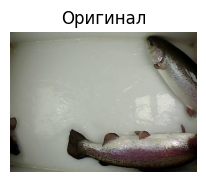

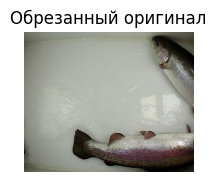

In [8]:
# Подгон
cropped = crop_sides_simple(img1, left_pixels=30, right_pixels=30)
plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')

plt.figure(figsize=(12, 4))
plt.subplot(2, 1, 2)
plt.imshow(cv2.cvtColor(cropped, cv2.COLOR_BGR2RGB))
plt.title('Обрезанный оригинал')
plt.axis('off')

In [9]:
img1 = crop_sides_simple(img1, left_pixels=30, right_pixels=30)
img2 = crop_sides_simple(img2, left_pixels=30, right_pixels=30)
img3 = crop_sides_simple(img3, left_pixels=30, right_pixels=30)
img4 = crop_sides_simple(img4, left_pixels=30, right_pixels=30)
img5 = crop_sides_simple(img5, left_pixels=30, right_pixels=30)
img6 = crop_sides_simple(img6, left_pixels=30, right_pixels=30)

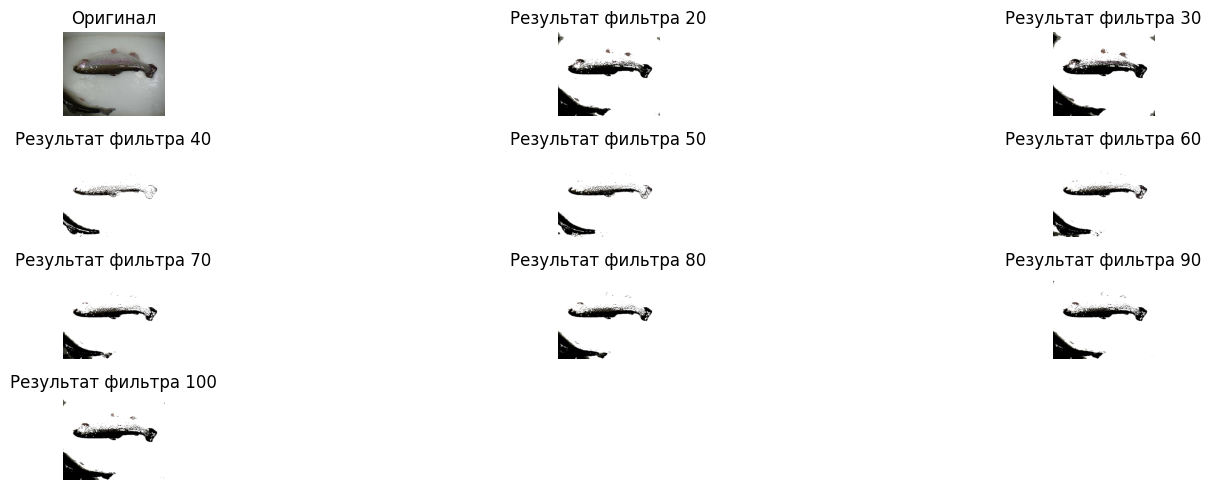

In [10]:
# Использование
results = []
image = img3
for t in range(20, 101, 10):
    results.append(enhance_extremes_filter(
        image, 
        black_threshold=t, 
        white_threshold=t
    ))

# Отображение
plt.figure(figsize=(15, 5))
plt.subplot(len(results)//2, 3, 1)
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Оригинал')
plt.axis('off')
for i in range(0, len(results)):
    plt.subplot(len(results)//2, 3, i+2)
    plt.imshow(cv2.cvtColor(results[i-2], cv2.COLOR_BGR2RGB))
    plt.title(f'Результат фильтра {20 + i * 10}')
    plt.axis('off')


plt.tight_layout()
plt.show()

За основу берем threshold = 60

# Алгоритм

## Preprocessing

### Детектор

In [5]:
class FishDetector:
    def __init__(self, 
                 history:int=100, 
                 varThreshold:int=50, 
                 min_area:int=800, 
                 max_area:int=5000, 
                 clipLimit:float=2.0, 
                 tileGridkernel:int=4, 
                 morph_kernel:int=7, 
                 g_blur:int=7, 
                 learning_rate:float=0.01, 
                 merge_threshold:int=50):
        self.bg_subtractor = cv2.createBackgroundSubtractorMOG2(
            history=history,
            varThreshold=varThreshold,
            detectShadows=False
        )
        self.min_area = min_area
        self.max_area = max_area
        self.clipLimit = clipLimit
        self.tileGridkernel = tileGridkernel
        self.g_blur = g_blur
        self.learning_rate = learning_rate
        self.merge_threshold = merge_threshold
        self.kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (morph_kernel, morph_kernel))
        
    def preprocess(self, frame):
        """Подготовка кадра - обрезка боков и улучшение контраста"""
        # Преобразование в оттенки серого
        gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        
        # Улучшение контраста для темных рыб
        clahe = cv2.createCLAHE(clipLimit=self.clipLimit, tileGridSize=(self.tileGridkernel, self.tileGridkernel))
        enhanced = clahe.apply(gray)
        
        # Легкое размытие для подавления шума
        blurred = cv2.GaussianBlur(enhanced, (self.g_blur, self.g_blur), 0)
        
        return blurred, frame
    
    def detect(self, frame):
        """Обнаружение рыб с улучшенной морфологией"""
        processed, original = self.preprocess(frame)
        
        # Фоновое вычитание
        fg_mask = self.bg_subtractor.apply(processed, learningRate=self.learning_rate)
        
        # Улучшенная морфология
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_CLOSE, self.kernel)
        fg_mask = cv2.morphologyEx(fg_mask, cv2.MORPH_OPEN, self.kernel)
        fg_mask = cv2.dilate(fg_mask, self.kernel, iterations=1)
        
        # Находим контуры
        contours, _ = cv2.findContours(fg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        bboxes = []
        valid_contours = []
        
        for contour in contours:
            area = cv2.contourArea(contour)
            
            # Фильтрация по размеру и форме
            if self.min_area < area < self.max_area:
                x, y, w, h = cv2.boundingRect(contour)
                
                # Фильтр по соотношению сторон
                aspect_ratio = w / h if h > 0 else 0
                if 0.3 < aspect_ratio < 3.0:
                    bboxes.append((x, y, w, h))
                    valid_contours.append(contour)
        if len(bboxes) > 1:
            bboxes = self._merge_close_boxes(bboxes)
    
        return bboxes, fg_mask, valid_contours, original
        
    def _merge_close_boxes(self, boxes):
        """Объединяет близко расположенные bounding boxes"""
        if not boxes:
            return boxes
        
        boxes = sorted(boxes, key=lambda b: b[0])
        merged = []
        current = list(boxes[0])
        
        for box in boxes[1:]:
            x1, y1, w1, h1 = current
            x2, y2, w2, h2 = box
            
            # Проверяем расстояние между боксами
            horizontal_gap = max(0, max(x1, x2) - min(x1 + w1, x2 + w2))
            vertical_gap = max(0, max(y1, y2) - min(y1 + h1, y2 + h2))
            min_distance = max(horizontal_gap, vertical_gap)
            
            # Проверяем перекрытие
            xi1 = max(x1, x2)
            yi1 = max(y1, y2)
            xi2 = min(x1 + w1, x2 + w2)
            yi2 = min(y1 + h1, y2 + h2)
            inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
            
            # Объединяем 
            if inter_area > 0 or min_distance < self.merge_threshold:
                new_x = min(x1, x2)
                new_y = min(y1, y2)
                new_w = max(x1 + w1, x2 + w2) - new_x
                new_h = max(y1 + h1, y2 + h2) - new_y
                current = [new_x, new_y, new_w, new_h]
            else:
                merged.append(tuple(current))
                current = list(box)
        
        merged.append(tuple(current))
        return merged

### Трекер

In [6]:
class FishTracker:
    def __init__(self, 
                 max_disappeared=30, 
                 max_distance=100, 
                 iou_threshold=0.1, 
                 min_hits=10):
        self.next_id = 0
        self.tracks = {}
        self.max_disappeared = max_disappeared
        self.max_distance = max_distance
        self.iou_threshold = iou_threshold
        self.min_hits = min_hits
        self.confirmed_tracks = set()
        
    @staticmethod
    def _calculate_iou(box1, box2):
        x1, y1, w1, h1 = box1
        x2, y2, w2, h2 = box2
        
        xi1 = max(x1, x2)
        yi1 = max(y1, y2)
        xi2 = min(x1 + w1, x2 + w2)
        yi2 = min(y1 + h1, y2 + h2)
        
        inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
        box1_area = w1 * h1
        box2_area = w2 * h2
        union_area = box1_area + box2_area - inter_area
        
        return inter_area / union_area if union_area > 0 else 0
    
    @staticmethod
    def _get_center(bbox):
        x, y, w, h = bbox
        return (int(x + w/2), int(y + h/2))
    
    def update(self, detections):
        if len(self.tracks) == 0:
            for bbox in detections:
                self._create_track(bbox)
            return self._get_active_tracks()
        
        if len(detections) == 0:
            for track_id in list(self.tracks.keys()):
                self.tracks[track_id]['disappeared'] += 1
                self.tracks[track_id]['age'] += 1
                if self.tracks[track_id]['disappeared'] > self.max_disappeared:
                    self._remove_track(track_id)
            return self._get_active_tracks()
        
        used_detections = set()
        
        for track_id, track in list(self.tracks.items()):
            if track['disappeared'] > 5:
                continue
                
            track_center = self._get_center(track['bbox'])
            best_match_idx = -1
            best_distance = float('inf')
            
            for i, bbox in enumerate(detections):
                if i in used_detections:
                    continue
                    
                det_center = self._get_center(bbox)
                distance = np.sqrt((det_center[0] - track_center[0])**2 + 
                                 (det_center[1] - track_center[1])**2)
                
                if distance < best_distance and distance < self.max_distance:
                    if det_center[0] > track_center[0] - 30:
                        best_distance = distance
                        best_match_idx = i
            
            if best_match_idx != -1:
                self.tracks[track_id]['bbox'] = detections[best_match_idx]
                self.tracks[track_id]['disappeared'] = 0
                self.tracks[track_id]['centroids'].append(self._get_center(detections[best_match_idx]))
                self.tracks[track_id]['hits'] += 1
                self.tracks[track_id]['age'] += 1
                
                if not self.tracks[track_id]['confirmed'] and self.tracks[track_id]['hits'] >= self.min_hits:
                    self.tracks[track_id]['confirmed'] = True
                    self.confirmed_tracks.add(track_id)
                
                used_detections.add(best_match_idx)
            else:
                self.tracks[track_id]['disappeared'] += 1
                self.tracks[track_id]['age'] += 1
        
        for i, bbox in enumerate(detections):
            if i not in used_detections:
                too_close = False
                det_center = self._get_center(bbox)
                
                for track_id, track in self.tracks.items():
                    if track['disappeared'] > 5:
                        continue
                        
                    track_center = self._get_center(track['bbox'])
                    distance = np.sqrt((det_center[0] - track_center[0])**2 + 
                                     (det_center[1] - track_center[1])**2)
                    
                    if distance < 60:
                        too_close = True
                        break
                
                if not too_close:
                    self._create_track(bbox)
        
        for track_id in list(self.tracks.keys()):
            if self.tracks[track_id]['disappeared'] > self.max_disappeared:
                self._remove_track(track_id)
        
        return self._get_active_tracks()
    
    def _create_track(self, bbox):
        self.tracks[self.next_id] = {
            'bbox': bbox,
            'centroids': deque([self._get_center(bbox)], maxlen=15),
            'age': 0,
            'hits': 1,
            'disappeared': 0,
            'confirmed': False,
            'created_at': time.time()
        }
        self.next_id += 1
    
    def _remove_track(self, track_id):
        if track_id in self.tracks:
            if track_id in self.confirmed_tracks:
                self.confirmed_tracks.remove(track_id)
            del self.tracks[track_id]
    
    def _get_active_tracks(self):
        active_tracks = {}
        
        for track_id, track in self.tracks.items():
            if track['disappeared'] <= self.max_disappeared and track['confirmed']:
                active_tracks[track_id] = {
                    'bbox': track['bbox'],
                    'center': track['centroids'][-1],
                    'centroids': list(track['centroids']),
                    'age': track['age'],
                    'hits': track['hits'],
                    'confirmed': track['confirmed']
                }
        
        return active_tracks

### Счетчик

In [7]:
class FishCounter:
    def __init__(self, count_line_x, direction='right', min_frames=3):
        self.count_line_x = count_line_x
        self.direction = direction
        self.min_frames = min_frames
        self.counted_ids = set()
        self.total_count = 0
        self.last_count_time = time.time()
        
    def update(self, tracks):  # Принимает tracks, а не detections!
        """Обновление счетчика"""
        new_count = 0
        
        for track_id, track in tracks.items():
            if track_id in self.counted_ids:
                continue
            
            center_x, _ = track['center']
            
            # Проверяем историю движения
            if len(track['centroids']) >= self.min_frames:
                # Определяем направление движения
                first_x = track['centroids'][0][0]
                last_x = track['centroids'][-1][0]
                
                if self.direction == 'right':
                    if first_x < self.count_line_x < last_x:
                        self.counted_ids.add(track_id)
                        new_count += 1
        
        self.total_count += new_count
        
        return self.total_count

### Пайплайн

In [8]:
class FishDetectionPipeline:
    def __init__(self, 
                 frame_width, 
                 count_line_ratio:float=0.85, 
                 direction:str='right',
                 history:int=100, 
                 varThreshold:int=50, 
                 min_area:int=700, 
                 max_area:int=10000, 
                 clipLimit:float=2.5, 
                 tileGridkernel:int=4, 
                 morph_kernel:int=7, 
                 g_blur:int=7, 
                 learning_rate:float=0.001, 
                 merge_threshold:int=50, 
                 max_disappeared=15, 
                 max_distance=300, 
                 iou_threshold=0.3, 
                 min_hits=10,
                 visualize:bool=True):
        
        self.detector = FishDetector(
            history=history, 
            varThreshold=varThreshold, 
            min_area=min_area, 
            max_area=max_area, 
            clipLimit=clipLimit, 
            tileGridkernel=tileGridkernel, 
            morph_kernel=morph_kernel, 
            g_blur=g_blur, 
            learning_rate=learning_rate, 
            merge_threshold=merge_threshold
        )
        self.tracker = FishTracker(
            max_disappeared=max_disappeared,
            max_distance=max_distance,
            iou_threshold=iou_threshold,
            min_hits=min_hits
        )
        self.counter = FishCounter(
            count_line_x=int(frame_width * count_line_ratio),
            direction=direction,
            min_frames=3
        )
        self.frame_count = 0
        self.visualize = visualize
    
    def process_frame(self, frame):
        """Обработка одного кадра"""
        # 1. Детекция
        bboxes, mask, contours, processed_frame = self.detector.detect(frame)
        
        # 2. Трекинг
        tracks = self.tracker.update(bboxes)
        
        # 3. Подсчет
        total_fish = self.counter.update(tracks)
        
        # 4. Визуализация
        if self.visualize:
            result_frame = self._visualize(
                processed_frame, tracks, contours, 
                mask, total_fish
            )
        else:
            result_frame = None
        
        self.frame_count += 1
        
        # Возвращаем разные значения в зависимости от визуализации
        if self.visualize:
            return result_frame, mask, total_fish, tracks
        else:
            return mask, total_fish, tracks, bboxes
    
    def _visualize(self, frame, tracks, contours, mask, total_fish):
        """Визуализация результатов (только если visualize=True)"""
        display = frame.copy()
        
        # Линия подсчета
        cv2.line(display, 
                (self.counter.count_line_x, 0),
                (self.counter.count_line_x, frame.shape[0]),
                (0, 255, 255), 3)
        
        # Контуры
        for contour in contours:
            if cv2.contourArea(contour) > 500:
                cv2.drawContours(display, [contour], -1, (0, 255, 0), 1)
        
        # Треки
        for track_id, track in tracks.items():
            # Bbox
            x, y, w, h = track['bbox']
            color = (0, 255, 0) if track_id not in self.counter.counted_ids else (0, 0, 255)
            cv2.rectangle(display, (x, y), (x+w, y+h), color, 2)
            
            # ID и возраст
            cv2.putText(display, f"ID:{track_id}", 
                       (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)
            
            # Линия пути
            centroids = track.get('centroids', [])
            if len(centroids) > 1:
                for i in range(1, len(centroids)):
                    cv2.line(display, centroids[i-1], centroids[i], (255, 255, 0), 1)
            
            # Центр
            center = track['center']
            cv2.circle(display, center, 4, color, -1)
            
            # Статус подсчета
            if track_id in self.counter.counted_ids:
                cv2.putText(display, "COUNTED", 
                           (x, y + h + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
        
        # Информационная панель
        info_y = 30
        cv2.putText(display, f"Total: {total_fish}", 
                   (10, info_y), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 2)
        cv2.putText(display, f"Active tracks: {len(tracks)}", 
                   (10, info_y + 60), cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
        cv2.putText(display, f"Frame: {self.frame_count}", 
                   (10, info_y + 90), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 1)
        
        # Координата линии
        cv2.putText(display, f"Line X: {self.counter.count_line_x}", 
                   (self.counter.count_line_x - 100, 30),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 255), 2)
        
        return display

# Проверка алгоритма

## Метрики

In [3]:
def mse(y_true: np.ndarray, y_pred: np.ndarray):
    """Среднеквадратичная ошибка"""
    return np.mean((y_true - y_pred) ** 2)

def mae(y_true: np.ndarray, y_pred: np.ndarray):
    """Средняя абсолютная ошибка"""
    return np.mean(np.abs(y_true - y_pred))
    

## Ручной тест

In [21]:
results = []
videos = [i for i in range(140, 150)]
counts = [55, 21, 21, 16, 45, 53, 0, 21, 19, 7]
visualize = False
param_name = 'min_hits'

# for param in range(3, 12, 1):
    # varThreshold 50 was the best -> 35
    # learning_rate 0.07 was the best -> 0.072
    # max_disappeared 30 -> zero influence

local_result = []
fps_results = []
processing_times = []

for i in range(len(videos)):
    print(f'Видео: {videos[i]}')
    
    pipeline = FishDetectionPipeline(
        frame_width=640,
        count_line_ratio=0.85,
        direction='right',
        history=55,
        varThreshold=35,
        min_area=700,
        max_area=10000,
        clipLimit=2.5,
        tileGridkernel=7,
        morph_kernel=3,
        g_blur=7,
        learning_rate=0.072,
        merge_threshold=110,
        max_disappeared=30,
        max_distance=280,
        iou_threshold=0.6,
        min_hits=7,
        visualize=visualize
    )
    
    cap = cv2.VideoCapture(f'data/videos/my_video-{videos[i]}.mkv')
    
    frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps_video = cap.get(cv2.CAP_PROP_FPS)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    pipeline.counter.count_line_x = int(frame_width * 0.85)
    
    frame_count = 0
    start_time = time.time()
    frame_times = []
    
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        frame_start = time.time()
        
        if visualize:
            result, mask, total_fish, tracks = pipeline.process_frame(frame)
            
            frame_end = time.time()
            frame_time = frame_end - frame_start
            frame_times.append(frame_time)
            
            current_fps = 1.0 / frame_time if frame_time > 0 else 0
            
            cv2.putText(result, f'FPS: {current_fps:.1f}', 
                       (frame_width - 150, 30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 2)
            
            cv2.imshow('Detection', result)
            cv2.imshow('Mask', mask)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            mask, total_fish, tracks, bbox = pipeline.process_frame(frame)
            frame_end = time.time()
            frame_times.append(frame_end - frame_start)
        
        frame_count += 1
        
        # # Выводим прогресс каждые 100 кадров
        # if frame_count % 100 == 0:
        #     elapsed = time.time() - start_time
        #     avg_fps = frame_count / elapsed if elapsed > 0 else 0
        #     print(f'  Обработано кадров: {frame_count}/{total_frames} '
        #           f'({frame_count/total_frames*100:.1f}%), '
        #           f'FPS: {avg_fps:.1f}')
    
    end_time = time.time()
    total_processing_time = end_time - start_time
    
    avg_frame_time = np.mean(frame_times) if frame_times else 0
    min_frame_time = np.min(frame_times) if frame_times else 0
    max_frame_time = np.max(frame_times) if frame_times else 0
    avg_fps = 1.0 / avg_frame_time if avg_frame_time > 0 else 0
    min_fps = 1.0 / max_frame_time if max_frame_time > 0 else 0
    max_fps = 1.0 / min_frame_time if min_frame_time > 0 else 0
    
    print(f'  Время обработки: {total_processing_time:.2f} сек')
    print(f'  Обработано кадров: {frame_count}')
    print(f'  Среднее время на кадр: {avg_frame_time*1000:.1f} мс')
    print(f'  Средний FPS: {avg_fps:.1f}')
    print(f'  Минимальный FPS: {min_fps:.1f}')
    print(f'  Максимальный FPS: {max_fps:.1f}')
    print(f'  Получено рыб: {total_fish}')
    print(f'  Ошибка: {abs(total_fish - counts[i])}')
    
    cap.release()
    local_result.append(total_fish)
    fps_results.append(avg_fps)
    processing_times.append(total_processing_time)

cv2.destroyAllWindows()

print("Общая статистика:")

for i in range(len(videos)):
    print(f'Видео {videos[i]}: {local_result[i]}/{counts[i]} рыб, '
          f'FPS: {fps_results[i]:.1f}, '
          f'Время: {processing_times[i]:.2f} сек')

print(f'\nСредние показатели:')
print(f'  Средний FPS: {np.mean(fps_results):.1f}')
print(f'  Минимальный FPS: {np.min(fps_results):.1f}')
print(f'  Максимальный FPS: {np.max(fps_results):.1f}')
print(f'  Общее время обработки: {np.sum(processing_times):.2f} сек')
print(f'  Среднее время на видео: {np.mean(processing_times):.2f} сек')

results.append({
    'mse': mse(np.array(counts), np.array(local_result)),
    'mae': mae(np.array(counts), np.array(local_result)),
    param_name: param,
    'avg_fps': np.mean(fps_results),
    'min_fps': np.min(fps_results),
    'max_fps': np.max(fps_results),
    'total_time': np.sum(processing_times),
    'predictions': local_result.copy()
})

results_sorted = sorted(results, key=lambda x: x['mse'])
print("РЕЗУЛЬТАТЫ ПО МЕТРИКАМ:")

for i, r in enumerate(results_sorted[:5]):
    print(f"{i+1}. MSE: {r['mse']:.2f}, "
          f"MAE: {r['mae']:.2f}, "
          f"Средний FPS: {r['avg_fps']:.1f}, "
          f"Параметр: {r.get(param_name, 'N/A')}")

Видео: 140
  Время обработки: 5.17 сек
  Обработано кадров: 3262
  Среднее время на кадр: 1.4 мс
  Средний FPS: 724.0
  Минимальный FPS: 326.3
  Максимальный FPS: 1259.2
  Получено рыб: 56
  Ошибка: 1
Видео: 141
  Время обработки: 1.92 сек
  Обработано кадров: 1196
  Среднее время на кадр: 1.4 мс
  Средний FPS: 710.9
  Минимальный FPS: 328.9
  Максимальный FPS: 1241.7
  Получено рыб: 20
  Ошибка: 1
Видео: 142
  Время обработки: 1.51 сек
  Обработано кадров: 899
  Среднее время на кадр: 1.5 мс
  Средний FPS: 679.1
  Минимальный FPS: 119.6
  Максимальный FPS: 1216.4
  Получено рыб: 23
  Ошибка: 2
Видео: 143
  Время обработки: 1.36 сек
  Обработано кадров: 860
  Среднее время на кадр: 1.4 мс
  Средний FPS: 725.5
  Минимальный FPS: 345.5
  Максимальный FPS: 1238.4
  Получено рыб: 16
  Ошибка: 0
Видео: 144
  Время обработки: 6.10 сек
  Обработано кадров: 4034
  Среднее время на кадр: 1.3 мс
  Средний FPS: 761.8
  Минимальный FPS: 297.4
  Максимальный FPS: 1259.9
  Получено рыб: 45
  Ошибка:

In [31]:
print(results)

[{'mse': np.float64(4.9), 'mae': np.float64(1.5)}]


## Подбор гиперпараметров

In [19]:
def hyperparameter_search(videos, counts, num_trials=200, visualize=False, 
                         results_file='hyperparameter_results.json'):
    # Параметры для перебора
    param_grid = {
        # параметры детектора
        'history': [i for i in range(40, 70, 5)], # История фона
        'varThreshold': [i for i in range(30, 71, 10)], # Порог вариации
        'min_area': [i for i in range(700, 901, 50)], # Минимальная площадь
        'max_area': [10000], # Максимальная площадь
        'clipLimit': [1.5, 2.0, 2.5, 3.0, 3.5], # Контраст CLAHE
        'tileGridkernel': [i for i in range(3, 10)], # Размер сетки CLAHE
        'morph_kernel': [i for i in range(3, 10)], # Ядро морфологии
        'g_blur': [i for i in range(3, 12, 2)], # Размытие Гаусса
        'learning_rate': [i/100 for i in range(1, 10)], # Скорость обучения фона
        'merge_threshold': [i for i in range(50, 121, 10)], # Порог объединения bbox
        
        # Параметры трекера
        'max_disappeared': [i for i in range(10, 31, 5)],
        'max_distance': [i for i in range(200, 411, 20)],
        'iou_threshold': [i/10 for i in range(1, 7)],
        'min_hits': [i for i in range(5, 10, 1)],
    }
    
    # Ключевые параметры для случайного поиска
    key_params = [
        'history',
        'varThreshold', 
        'min_area',
        'clipLimit',
        'tileGridkernel',
        'morph_kernel',
        'g_blur',
        'learning_rate',
        'merge_threshold',
        'max_disappeared',
        'max_distance',
        'iou_threshold',
        'min_hits'
    ]
    
    results = []
    
    try:
        with open(results_file, 'r') as f:
            existing_results = json.load(f)
            results = existing_results
            print(f"Кол-во существующих результатов в файле {len(results)}")
    except FileNotFoundError:
        print("Начало поиска")
    except json.JSONDecodeError:
        print("Ошибка чтения файла")
    
    # Генерируем случайные комбинации
    test_combinations = []
    for _ in range(num_trials):
        combo = {}
        for param in key_params:
            combo[param] = random.choice(param_grid[param])
        test_combinations.append(combo)
    
    # Основной цикл перебора
    pbar = tqdm(test_combinations, desc="Подбор параметров", 
                bar_format='{l_bar}{bar:30}{r_bar}{bar:-30b}')
    
    for combo in pbar:
        try:
            already_tested = any(
                all(combo.get(k) == r['params'].get(k) for k in key_params)
                for r in results
            )
            if already_tested:
                continue
            
            local_result = []
            
            for video_idx, video_name in enumerate(videos):
                pipeline = FishDetectionPipeline(
                    frame_width=640,
                    count_line_ratio=0.85,
                    direction='right',
                    visualize=visualize,
                    **combo  # Анпакинг параметров
                )
                
                # Обработка видео
                cap = cv2.VideoCapture(video_name)
                if not cap.isOpened():
                    print(f"Ошибка: не удалось открыть видео {video_name}")
                    local_result.append(0)
                    continue
                
                # Получаем реальную ширину кадра
                frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                pipeline.counter.count_line_x = int(frame_width * 0.85)
                
                total_fish = 0
                
                while True:
                    ret, frame = cap.read()
                    if not ret:
                        break
                    
                    if visualize:
                        result_frame, _, current_total, _ = pipeline.process_frame(frame)
                    else:
                        _, current_total, _, _ = pipeline.process_frame(frame)
                    
                    total_fish = current_total
                
                cap.release()
                local_result.append(total_fish)
            
            # Вычисляем ошибки
            if len(local_result) == len(counts):
                errors = [abs(local_result[i] - counts[i]) for i in range(len(videos))]
                total_error = sum(errors)
                mse_val = mse(np.array(counts), np.array(local_result))
                mae_val = mae(np.array(counts), np.array(local_result))
                
                # Сохраняем результат
                result_entry = {
                    'mse': float(mse_val),
                    'mae': float(mae_val),
                    'predicted': local_result.copy(),
                    'errors': errors.copy(),
                    'total_error': total_error,
                    'params': combo.copy()
                }
                
                results.append(result_entry)
                
                # Промежуточное сохранение после каждой итерации
                with open(results_file, 'w') as f:
                    json.dump(results, f, indent=2)
                
                # Обновляем прогресс-бар
                pbar.set_postfix({
                    'err': total_error,
                    'saved': len(results)
                })
                
        except Exception as e:
            print(f"Ошибка: {str(e)[:50]}...")
            continue
    
    # Анализ результатов
    print(f"\Подбор завершен")
    
    # Сортируем по общей ошибке
    results_sorted = sorted(results, key=lambda x: x['total_error'])
    
    # Финальное сохранение отсортированных результатов
    with open(results_file, 'w') as f:
        json.dump(results_sorted, f, indent=2)
    
    print("5 лучших комбинаций:")
    
    for i, r in enumerate(results_sorted[:5]):
        print(f"\n{i+1:2d}. Ошибка: {r['total_error']:2d}")
        print(f"    Предсказано: {r['predicted']}")
        print(f"    Фактически:   {counts}")
    
    # Статистика
    perfect_matches = sum(1 for r in results if r['total_error'] == 0)
    print(f"\nСтатистика:")
    print(f"  Идеальных совпадений: {perfect_matches}/{len(results)}")
    
    print(f"\nРезультаты сохранены в {results_file}")
    
    return results_sorted

In [20]:
test_videos = ['data/videos/my_video-140.mkv', 'data/videos/my_video-141.mkv', 'data/videos/my_video-142.mkv',
              'data/videos/my_video-143.mkv', 'data/videos/my_video-144.mkv', 'data/videos/my_video-145.mkv']  # Пример
test_counts = [55, 21, 21, 16, 45, 53]

best_results = hyperparameter_search(
    videos=test_videos,
    counts=test_counts,
    num_trials=1000,
    visualize=False,
    results_file='hyperparameter_results_new.json'
)

if best_results:
    print(f"\nЛУЧШАЯ КОМБИНАЦИЯ:")
    print(f"Ошибка: {best_results[0]['total_error']}")
    print(f"Параметры: {json.dumps(best_results[0]['params'], indent=2)}")

Случайный поиск гиперпараметров (1000 комбинаций)...
Загружено 32 существующих результатов


Подбор параметров:  29%|████████▋                     | 290/1000 [1:59:15<4:51:58, 24.67s/it, err=52, saved=322]       


KeyboardInterrupt: 

## Анализ результатов

In [13]:
def json_to_dataframe(json_file: str) -> pd.DataFrame:
    with open(json_file, 'r') as f:
        data = json.load(f)
    
    df = pd.DataFrame(data)
    
    if 'params' in df.columns:
        params_df = pd.json_normalize(df['params'])
        params_df = params_df.add_prefix('param_')
        df = pd.concat([df.drop(columns=['params']), params_df], axis=1)
    
    if 'errors' in df.columns:
        max_videos = df['errors'].apply(len).max()
        for i in range(max_videos):
            df[f'error_video_{i+1}'] = df['errors'].apply(
                lambda x: x[i] if i < len(x) else None
            )
        df = df.drop(columns=['errors'])
    
    if 'predicted' in df.columns:
        max_videos = df['predicted'].apply(len).max()
        for i in range(max_videos):
            df[f'predicted_video_{i+1}'] = df['predicted'].apply(
                lambda x: x[i] if i < len(x) else None
            )
        df = df.drop(columns=['predicted'])
    
    if 'total_error' in df.columns:
        df = df.sort_values('total_error').reset_index(drop=True)
        df.insert(0, 'rank', range(1, len(df) + 1))
    
    return df

In [14]:
pd.set_option('display.max_columns', None)
df = json_to_dataframe('hyperparameter_results_new.json')

In [23]:
df.head(15)

,rank,mse,mae,total_error,param_history,param_varThreshold,param_min_area,param_clipLimit,param_tileGridkernel,param_morph_kernel,param_g_blur,param_learning_rate,param_merge_threshold,param_max_disappeared,param_max_distance,param_iou_threshold,param_min_hits,error_video_1,error_video_2,error_video_3,error_video_4,error_video_5,error_video_6,predicted_video_1,predicted_video_2,predicted_video_3,predicted_video_4,predicted_video_5,predicted_video_6
0,1,0.500000,0.500000,3,55,50,700,2.5,7,3,7,0.07,110,30,280,0.6,7,1,1,0,1,0,0,54,20,21,17,45,53
1,2,3.000000,1.000000,6,55,50,800,3.5,6,6,7,0.04,50,20,200,0.3,8,0,0,4,1,1,0,55,21,25,15,44,53
2,3,2.500000,1.166667,7,45,60,900,1.5,4,3,7,0.06,100,30,260,0.4,5,0,3,1,2,1,0,55,18,22,14,46,53
3,4,1.833333,1.166667,7,55,40,700,1.5,6,7,3,0.08,110,15,380,0.1,9,0,1,1,1,2,2,55,22,22,15,43,51
4,5,3.500000,1.166667,7,65,70,800,3.5,8,8,11,0.05,80,30,240,0.1,8,1,0,0,2,4,0,56,21,21,18,49,53
5,6,3.333333,1.333333,8,45,70,800,3.5,9,5,7,0.07,110,15,320,0.4,6,3,0,3,1,1,0,52,21,24,15,44,53
6,7,2.666667,1.333333,8,60,60,850,1.5,8,7,9,0.06,50,10,240,0.6,9,1,3,1,0,2,1,56,18,20,16,47,52
7,8,3.666667,1.333333,8,50,30,850,2.0,8,6,5,0.05,50,10,200,0.5,8,4,0,0,1,1,2,51,21,21,15,44,51
8,9,2.666667,1.333333,8,65,60,800,3.5,5,9,7,0.07,110,20,360,0.3,9,1,1,1,0,2,3,54,20,20,16,47,56
9,10,2.666667,1.333333,8,65,40,850,3.0,8,9,9,0.08,120,25,380,0.2,9,0,1,2,1,3,1,55,20,19,15,48,54


In [24]:
df.tail(20)

,rank,mse,mae,total_error,param_history,param_varThreshold,param_min_area,param_clipLimit,param_tileGridkernel,param_morph_kernel,param_g_blur,param_learning_rate,param_merge_threshold,param_max_disappeared,param_max_distance,param_iou_threshold,param_min_hits,error_video_1,error_video_2,error_video_3,error_video_4,error_video_5,error_video_6,predicted_video_1,predicted_video_2,predicted_video_3,predicted_video_4,predicted_video_5,predicted_video_6
302,303,291.166667,16.166667,97,45,70,700,1.5,7,9,3,0.01,110,10,340,0.1,7,23,10,12,11,18,23,32,11,9,5,27,30
303,304,347.333333,16.333333,98,40,50,800,3.5,3,4,9,0.02,110,10,300,0.6,9,25,7,8,8,21,29,30,14,13,8,24,24
304,305,318.000000,16.666667,100,50,40,800,2.5,9,3,5,0.01,100,10,320,0.1,9,22,13,11,9,18,27,33,8,10,7,27,26
305,306,346.166667,17.166667,103,65,30,750,1.5,7,8,11,0.02,120,20,260,0.2,8,25,11,12,11,15,29,30,10,9,5,30,24
306,307,362.500000,17.500000,105,60,50,850,1.5,8,9,11,0.01,60,10,260,0.3,6,28,10,12,9,21,25,27,11,9,7,24,28
307,308,407.000000,17.666667,106,50,40,700,3.5,6,5,3,0.06,50,30,380,0.4,5,31,7,8,10,22,28,86,28,29,26,67,81
308,309,373.666667,17.666667,106,50,30,900,3.5,6,5,7,0.01,90,20,260,0.4,9,24,12,10,9,21,30,31,9,11,7,24,23
309,310,378.833333,17.833333,107,65,60,700,2.5,4,7,7,0.01,90,25,260,0.6,9,28,14,8,10,20,27,27,7,13,6,25,26
310,311,436.000000,18.000000,108,60,30,750,3.0,4,4,5,0.06,50,10,360,0.2,5,34,9,12,7,15,31,89,30,33,23,60,84
311,312,380.333333,18.000000,108,60,70,800,1.5,6,6,3,0.01,100,10,260,0.5,7,28,13,11,10,18,28,27,8,10,6,27,25


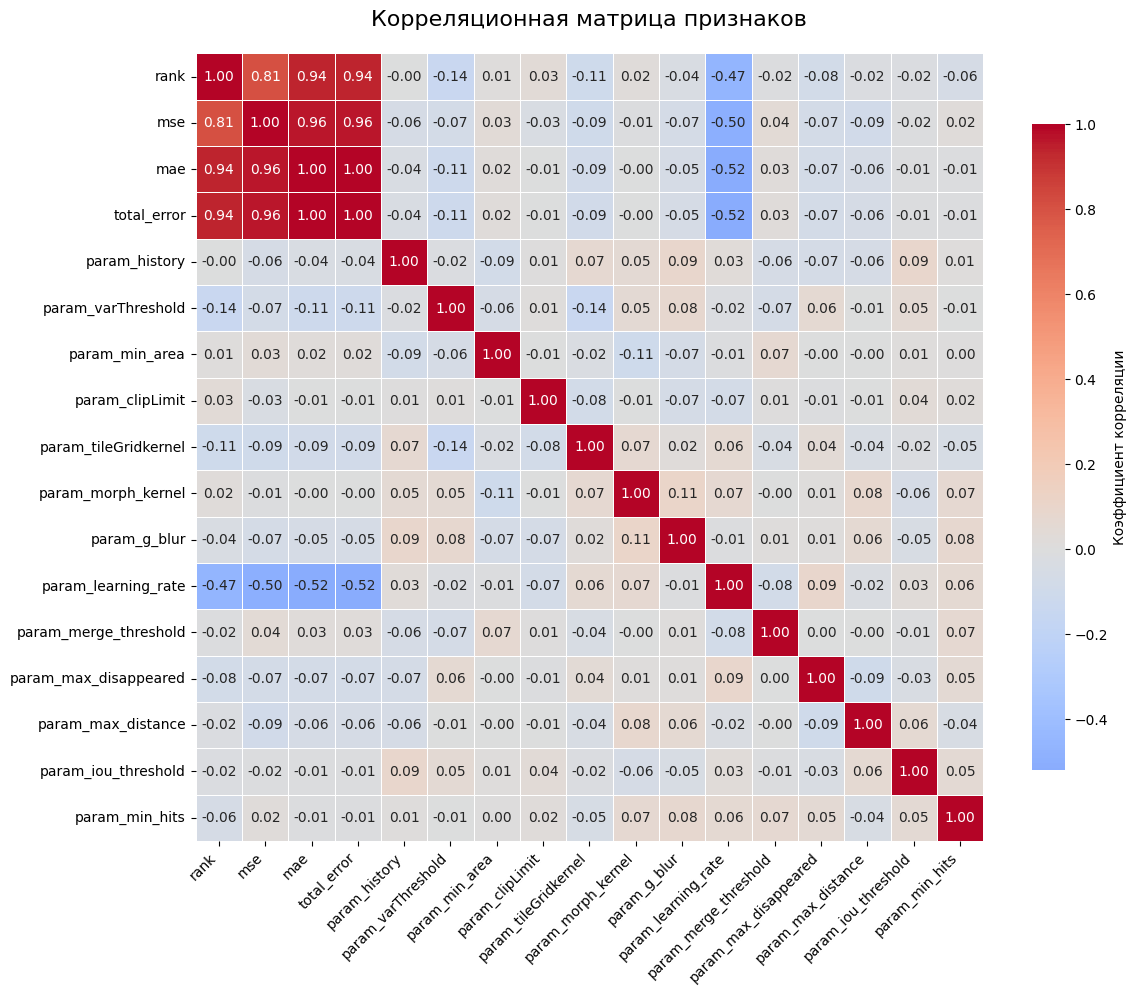

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

df_temp = df.drop(['predicted_video_1', 'predicted_video_2', 'predicted_video_3',
                  'predicted_video_4', 'predicted_video_5', 'predicted_video_6',
                  'error_video_1', 'error_video_2', 'error_video_3',
                  'error_video_4', 'error_video_5', 'error_video_6'], axis=1)
corr = df_temp.corr()

plt.figure(figsize=(12, 10))

heatmap = sns.heatmap(
    corr,
    annot=True,          
    fmt=".2f",          
    cmap="coolwarm",
    center=0,
    square=True,
    linewidths=0.5,
    linecolor='white', 
    cbar_kws={"shrink": 0.8, "label": "Коэффициент корреляции"}
)

plt.title("Корреляционная матрица признаков", fontsize=16, pad=20)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('corr.png')

plt.show()
